## Model building and training

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fingerprints.get_fp import output, input
from useful_functions import plot_cluster_counts_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
%matplotlib inline

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn import utils


## Importing data

In [2]:
labels_kmeans_9 = pd.read_csv('data/labels_kmeans_9.csv').set_index('CID')
labels_kmeans_11 = pd.read_csv('data/labels_kmeans_11.csv').set_index('CID')
labels_manual = pd.read_csv('data/labels_manual.csv').set_index('CID')
labels_manual_expert = pd.read_csv('data/labels_manual_expert.csv').set_index('CID')
labels_missing_in_expert = pd.read_csv('data/missing_in_expert.csv').set_index('CID')

kmeans_counts = labels_kmeans_9.sum().sort_values(ascending=False)
manual_counts = labels_manual.sum().sort_values(ascending=False)
manual_expert_counts = labels_manual_expert.sum().sort_values(ascending=False)

print(manual_counts,manual_expert_counts)

fingerprint = input

fruity        1736
general       1287
spices        1189
sweet         1170
savoury       1136
green         1101
earthy        1050
sharp          635
artificial     247
dtype: int64 fruity     1754
savory     1446
green       926
flower      682
herbal      600
aquatic     436
alcohol     339
woody       233
earthy      173
spices      101
animal       64
dtype: int64


# 9 k-means vs. 9 manual clusters

## Randomized labels as baseline

In [47]:
# Randomize labels by shuffling each column independently
randomized_labels = labels_kmeans_9.apply(np.random.permutation, axis=0)

y_rand = np.array(randomized_labels, dtype=np.float64)
X = fingerprint

X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X, y_rand, test_size=0.2, random_state=12345)
print(f"training set with standard split is {len(y_train_rand)} items long and the test set is {len(y_test_rand)} items long")

m_rf = RandomForestClassifier(n_estimators = 10, max_features=100).fit(X_train_rand, y_train_rand)
y_pred_std = m_rf.predict(X_test_rand)

print(classification_report(y_test_rand, y_pred_std, zero_division=0))

training set with standard split is 2789 items long and the test set is 698 items long
              precision    recall  f1-score   support

           0       0.18      0.05      0.07       154
           1       0.26      0.07      0.11       171
           2       0.17      0.07      0.10       140
           3       0.20      0.06      0.09       198
           4       0.36      0.21      0.26       282
           5       0.41      0.23      0.29       260
           6       0.00      0.00      0.00        83
           7       0.29      0.06      0.10       158
           8       0.43      0.32      0.37       288

   micro avg       0.34      0.15      0.21      1734
   macro avg       0.26      0.12      0.15      1734
weighted avg       0.30      0.15      0.19      1734
 samples avg       0.23      0.15      0.16      1734



## Train-test split

In [48]:
y = np.array(labels_kmeans_9, dtype=np.float64)
X = fingerprint
X

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [49]:
from skmultilearn.model_selection import iterative_train_test_split

X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X, y, test_size=0.2, random_state=12345)
print(f"training set with standard split is {len(y_train_std)} items long and the test set is {len(y_test_std)} items long")

X_train_iter, y_train_iter, X_test_iter, y_test_iter = iterative_train_test_split(X, y, test_size = 0.2)
print(f"training set with iterative split is {len(y_train_iter)} items long and the test set is {len(y_test_iter)} items long")

training set with standard split is 2789 items long and the test set is 698 items long
training set with iterative split is 2789 items long and the test set is 698 items long


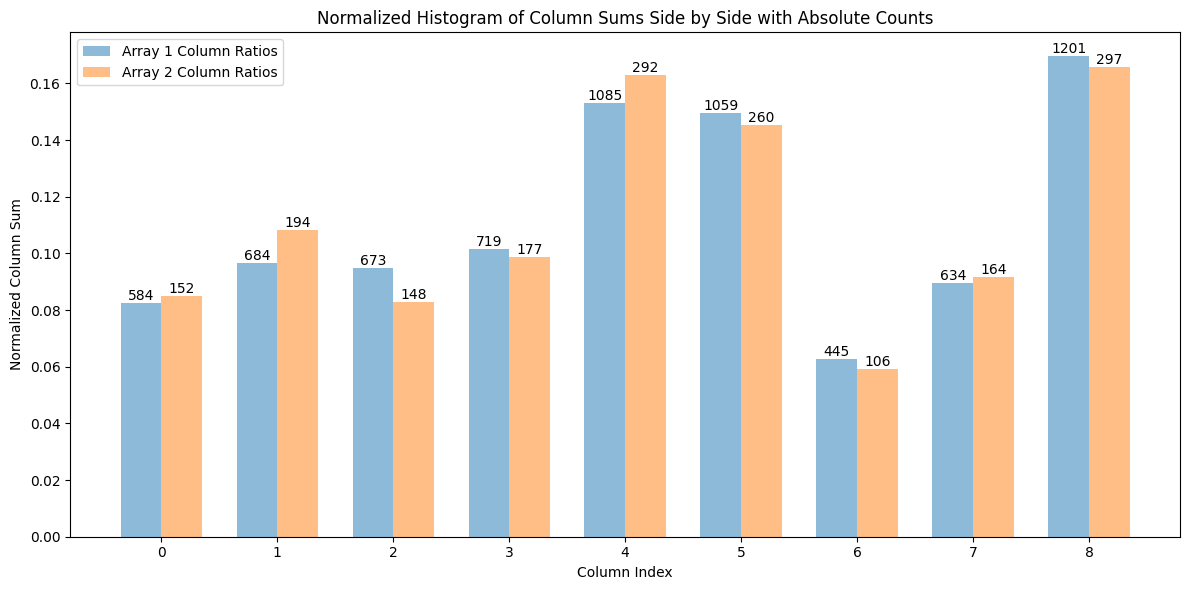

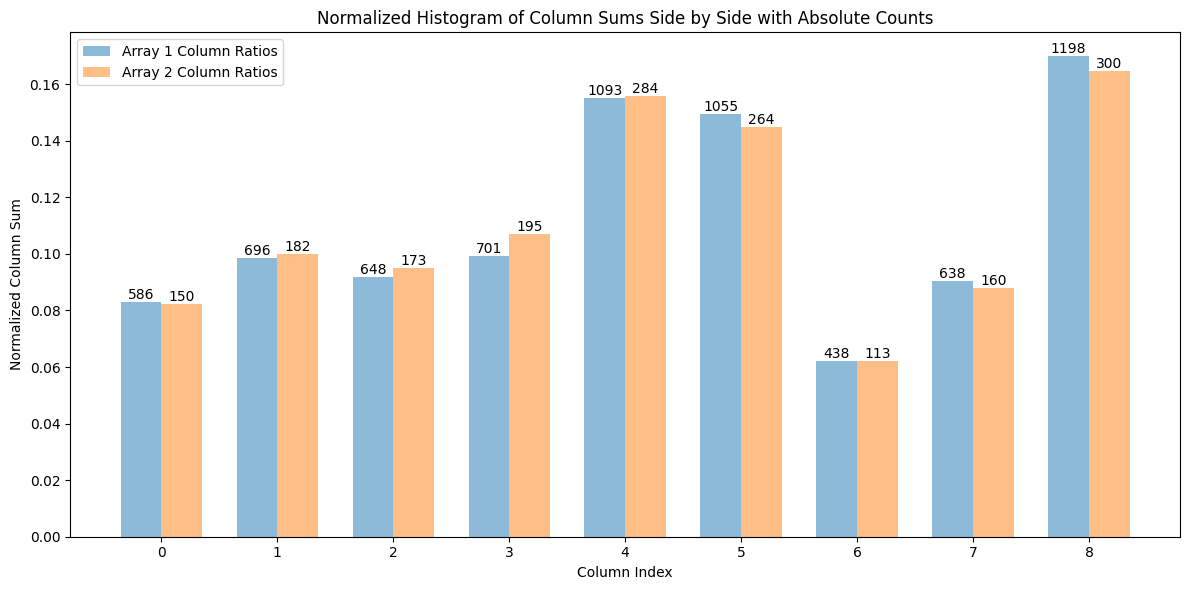

In [50]:
plot_cluster_counts_array(y_train_std, y_test_std)
plot_cluster_counts_array(y_train_iter, y_test_iter)

## Training unoptimized models

In [51]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 1).fit(X_train_std, y_train_std)
y_pred_std = m_rf.predict(X_test_std)

print(classification_report(y_test_std, y_pred_std, zero_division=0))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50       152
           1       0.60      0.39      0.47       194
           2       0.48      0.24      0.32       148
           3       0.66      0.37      0.47       177
           4       0.80      0.57      0.67       292
           5       0.71      0.50      0.59       260
           6       0.59      0.21      0.31       106
           7       0.70      0.38      0.49       164
           8       0.72      0.62      0.66       297

   micro avg       0.69      0.45      0.54      1790
   macro avg       0.66      0.41      0.50      1790
weighted avg       0.68      0.45      0.53      1790
 samples avg       0.64      0.48      0.51      1790



In [52]:
m_rf_unoptimized = RandomForestClassifier(n_estimators = 10, max_features = 1).fit(X_train_iter, y_train_iter)
y_pred_unoptimized = m_rf_unoptimized.predict(X_test_iter)

print(classification_report(y_test_iter, y_pred_unoptimized, zero_division=0))

              precision    recall  f1-score   support

           0       0.55      0.34      0.42       150
           1       0.60      0.33      0.43       182
           2       0.46      0.19      0.27       173
           3       0.63      0.21      0.31       195
           4       0.78      0.57      0.66       284
           5       0.75      0.54      0.63       264
           6       0.43      0.18      0.25       113
           7       0.67      0.36      0.47       160
           8       0.63      0.60      0.61       300

   micro avg       0.65      0.41      0.50      1821
   macro avg       0.61      0.37      0.45      1821
weighted avg       0.64      0.41      0.49      1821
 samples avg       0.62      0.43      0.48      1821



Performance seems to be better when using the standard train test split function compared to the iterative train test function, so we will use the standard train test function 

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
print(f"training set with standard split is {len(y_train)} items long and the test set is {len(y_test)} items long")

training set with standard split is 2789 items long and the test set is 698 items long


In [54]:
print(np.sum(y_test, axis=0))
print(np.sum(y_pred_std, axis=0))


[152. 194. 148. 177. 292. 260. 106. 164. 297.]
[ 91. 124.  75.  98. 210. 184.  37.  89. 257.]


In [18]:
#m_rf.get_params()

## Bayesian hyperparameter optimisation

In [15]:
# functions derived from ...
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.metrics import make_scorer, f1_score

# inlcude max leaf nodes?
def rfc_cv(n_estimators, max_leaf_nodes, max_depth, min_samples_split, max_features,  x_data, y_targets):
    """Random Forest cross validation.

    This function will instantiate a random forest classifier with parameters
    n_estimators, min_samples_split, and max_depth. Combined with data and
    targets this will in turn be used to perform cross validation. The result
    of cross validation is returned.

    Our goal is to find combinations of n_estimators, min_samples_split, and
    max_depth that minimizes the log loss.
    """
    estimator = RandomForestClassifier(
        n_estimators=n_estimators,
        max_leaf_nodes=max_leaf_nodes,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2
    )

    multi_output_estimator = MultiOutputClassifier(estimator)
    
    cval = cross_val_score(multi_output_estimator, x_data, y_targets,
                           scoring=make_scorer(f1_score, average='samples'), cv=4)
    return cval.mean()

In [36]:

def optimize_rfc(x_data, y_targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rfc_crossval(n_estimators, max_leaf_nodes, max_depth, min_samples_split, max_features):
        """Wrapper of RandomForest cross validation.
        """
        return rfc_cv(
            n_estimators=int(n_estimators),
            max_leaf_nodes = int(max_leaf_nodes),
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            max_features=int(max_features),
            x_data=x_data,
            y_targets=y_targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 750),
            "max_leaf_nodes" : (20, 1000),
            "max_depth": (20, 100),
            "min_samples_split": (2, 25),
            "max_features": (3, 500),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)
    return optimizer.max["params"]

In [17]:
best_params_bayes = optimize_rfc(X_train, y_train)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.5873    | 35.32     | 312.2     | 449.0     | 20.06     | 587.2     |
| 2         | 0.5872    | 41.81     | 140.4     | 805.8     | 24.04     | 658.2     |
| 3         | 0.5852    | 48.63     | 252.0     | 689.8     | 18.39     | 284.0     |
| 4         | 0.5639    | 64.9      | 253.0     | 33.49     | 19.78     | 663.2     |
| 5         | 0.5881    | 49.19     | 308.9     | 93.87     | 10.48     | 700.5     |
| 6         | 0.5915    | 61.22     | 93.2      | 389.5     | 3.748     | 204.4     |
| 7         | 0.5896    | 50.6      | 411.3     | 416.9     | 19.22     | 584.0     |
| 8         | 0.5849    | 28.88     | 111.6     | 678.1     | 21.77     | 600.1     |
| 9         | 0.5891    | 48.69     | 406.7     | 406.3     | 13.31     | 588.8     |
| 10        | 0.5805    | 36.09     | 51.05     | 427.

## Random & Grid Search

In [55]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint as sp_randint
import numpy as np
import time

def optimize_rfc_grid_search(x_data, y_targets):
    # Random Forest classifier to be optimized
    rfc = RandomForestClassifier(random_state=2)

    # Step 1: Define the parameter space for RandomizedSearchCV
    param_dist = {
        "n_estimators": sp_randint(10, 750),
        "max_leaf_nodes": sp_randint(20, 1000),
        "max_depth": sp_randint(20, 500),
        "min_samples_split": sp_randint(2, 250),
        "max_features": sp_randint(3, 100)
    }

    # Step 2: Execute RandomizedSearchCV
    n_iter_search = 50  # Number of parameter settings that are sampled
    random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=make_scorer(f1_score, average='micro'), cv=4, verbose=1)
    
    start_time = time.time()
    random_search.fit(x_data, y_targets)

    print(f"Random Search completed in {time.time() - start_time:.2f} seconds. Starting Grid Search...")

    # Step 3: Identify the best parameters from the random search
    best_params = random_search.best_params_

    # Step 4: Define a narrower search space for GridSearchCV around the best parameters found
    param_grid = {
        "n_estimators": [best_params['n_estimators'] - 10, best_params['n_estimators'], best_params['n_estimators'] + 10],
        "max_leaf_nodes": [best_params['max_leaf_nodes'] - 20, best_params['max_leaf_nodes'], best_params['max_leaf_nodes'] + 20],
        "max_depth": [best_params['max_depth'] - 20, best_params['max_depth'], best_params['max_depth'] + 20],
        "min_samples_split": [best_params['min_samples_split'] - 10, best_params['min_samples_split'], best_params['min_samples_split'] + 10],
        "max_features": [max(1, best_params['max_features'] - 10), best_params['max_features'], best_params['max_features'] + 10]
    }

    # Step 5: Execute GridSearchCV
    grid_search = GridSearchCV(rfc, param_grid=param_grid, scoring=make_scorer(f1_score, average='micro'), cv=4, verbose=1)

    # Adjust ranges to ensure they are valid (e.g., positive integers)
    for key in param_grid.keys():
        param_grid[key] = [np.max([x, param_dist[key].a]) for x in param_grid[key]]  # Ensure within original bounds

    start_time = time.time()

    grid_search.fit(x_data, y_targets)

    print(f"Grid Search completed in {time.time() - start_time:.2f} seconds.")

    # Step 6: Report the best parameters found
    print("Best parameters found by grid search:", grid_search.best_params_)
    return grid_search.best_params_

# Call the function with your data and target variables
# best_params = optimize_rfc_with_random_and_grid_search(x_data, y_targets)

### Optimization and model training (k-means)

In [56]:
best_params_grid_kmeans_9 = optimize_rfc_grid_search(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Random Search completed in 255.56 seconds. Starting Grid Search...
Fitting 4 folds for each of 243 candidates, totalling 972 fits
Grid Search completed in 771.15 seconds.
Best parameters found by grid search: {'max_depth': 48, 'max_features': 89, 'max_leaf_nodes': 697, 'min_samples_split': 2, 'n_estimators': 103}


In [57]:
m_rf_kmeans_9_optimized = RandomForestClassifier(n_estimators = int(best_params_grid_kmeans_9["n_estimators"]), max_depth = int(best_params_grid_kmeans_9["max_depth"]), max_leaf_nodes = int(best_params_grid_kmeans_9["max_leaf_nodes"]), min_samples_split = int(best_params_grid_kmeans_9["min_samples_split"]), max_features = int(best_params_grid_kmeans_9["max_features"])).fit(X_train, y_train)
y_pred = m_rf_kmeans_9_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56       152
           1       0.68      0.45      0.54       194
           2       0.47      0.24      0.32       148
           3       0.75      0.35      0.48       177
           4       0.83      0.63      0.71       292
           5       0.74      0.58      0.65       260
           6       0.63      0.34      0.44       106
           7       0.71      0.52      0.60       164
           8       0.72      0.68      0.70       297

   micro avg       0.71      0.51      0.60      1790
   macro avg       0.69      0.47      0.56      1790
weighted avg       0.71      0.51      0.59      1790
 samples avg       0.69      0.55      0.58      1790



In [120]:
print(m_rf_kmeans_9_optimized.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 387, 'max_features': 45, 'max_leaf_nodes': 892, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 720, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


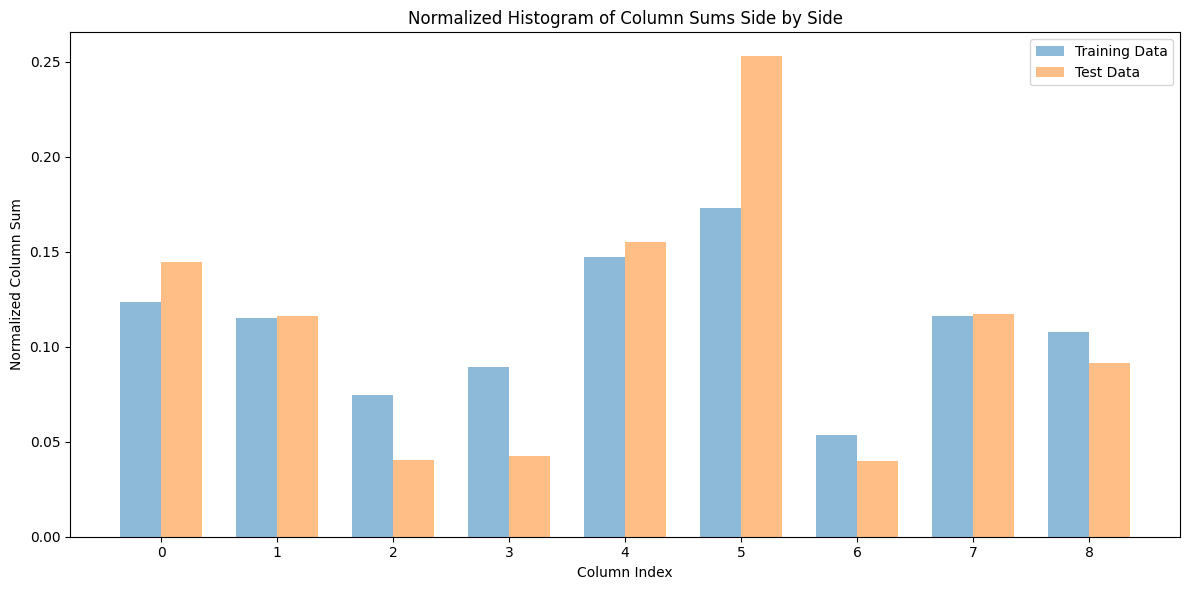

[245. 228. 148. 177. 292. 343. 106. 231. 214.]
[201. 161.  56.  59. 215. 351.  55. 163. 127.]
[0 1 2 3 4 5 6 7 8]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]] [[0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [121]:
# plot_cluster_counts_array(y_test, y_pred)

print(np.sum(y_test, axis=0))
print(np.sum(y_pred, axis=0))
print(np.array([0,1,2,3,4,5,6,7,8]))

m_rf_kmeans_9_optimized.get_params()

print(y_test, y_pred)

### Optimization and model training (manual)

In [61]:
y = labels_manual
X = fingerprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [62]:
best_params_grid_manual = optimize_rfc_grid_search(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Random Search completed in 218.22 seconds. Starting Grid Search...
Fitting 4 folds for each of 243 candidates, totalling 972 fits
Grid Search completed in 2043.43 seconds.
Best parameters found by grid search: {'max_depth': 66, 'max_features': 107, 'max_leaf_nodes': 587, 'min_samples_split': 2, 'n_estimators': 270}


In [63]:
m_rf_manual_optimized = RandomForestClassifier(n_estimators = int(best_params_grid_manual["n_estimators"]), max_depth = int(best_params_grid_manual["max_depth"]), max_leaf_nodes = int(best_params_grid_manual["max_leaf_nodes"]), min_samples_split = int(best_params_grid_manual["min_samples_split"]), max_features = int(best_params_grid_manual["max_features"])).fit(X_train, y_train)
y_pred = m_rf_manual_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       363
           1       0.67      0.44      0.53       206
           2       0.75      0.41      0.53       219
           3       0.72      0.44      0.55       202
           4       0.75      0.56      0.64       218
           5       0.74      0.62      0.68       249
           6       0.76      0.24      0.36        55
           7       0.68      0.22      0.34       126
           8       0.64      0.39      0.48       275

   micro avg       0.74      0.50      0.60      1913
   macro avg       0.73      0.45      0.54      1913
weighted avg       0.73      0.50      0.59      1913
 samples avg       0.72      0.53      0.57      1913



## Feature importance

In [64]:
def feature_importance(model, X_train):

    # Extract feature importances
    feature_importances = model.feature_importances_

    # Create generic feature names if not already provided
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f"Bit {i}" for i in range(X_train_std.shape[1])]

    # Sort the feature importances in descending order and get the indices
    indices = np.argsort(feature_importances)[::-1]

    # Select the top 50 features
    top_indices = indices[:50]
    
    # Adjust the size of the plot to accommodate 50 features nicely
    plt.figure(figsize=(15, 10))
    plt.title("Top 50 Feature Importances")
    plt.bar(range(50), feature_importances[top_indices], color="r", align="center")
    
    # Set the ticks to be the names of the top 50 features
    plt.xticks(range(50), [feature_names[i] for i in top_indices], rotation=90)
    plt.xlim([-1, 50])
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

### K-means

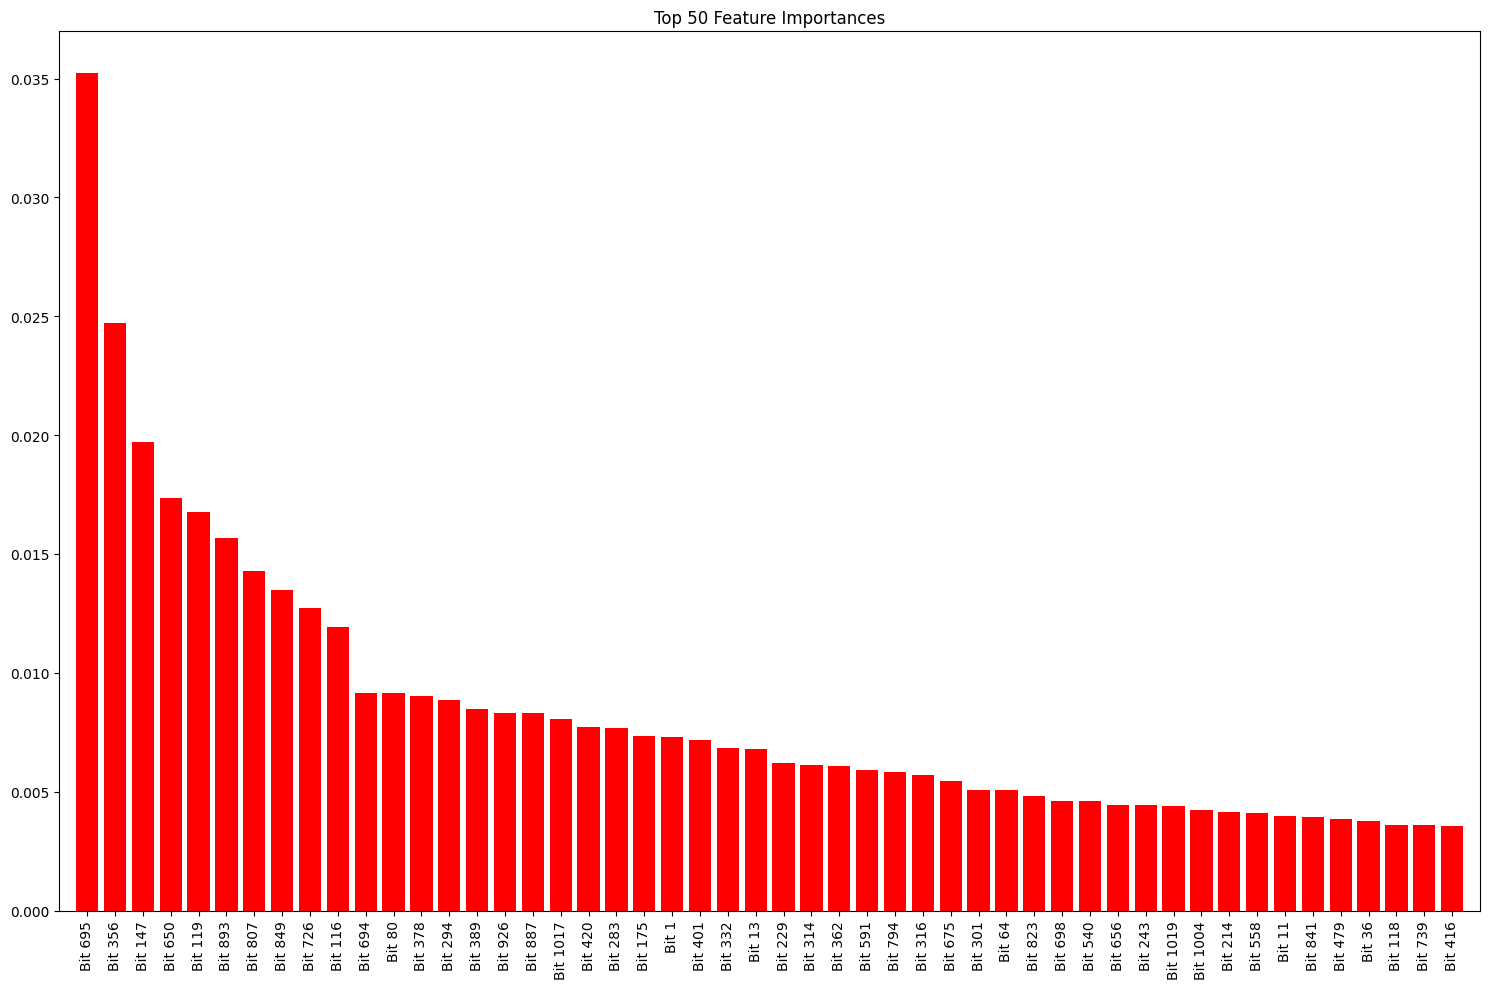

In [65]:
feature_importance(m_rf_kmeans_9_optimized, X_train)

### Manual 

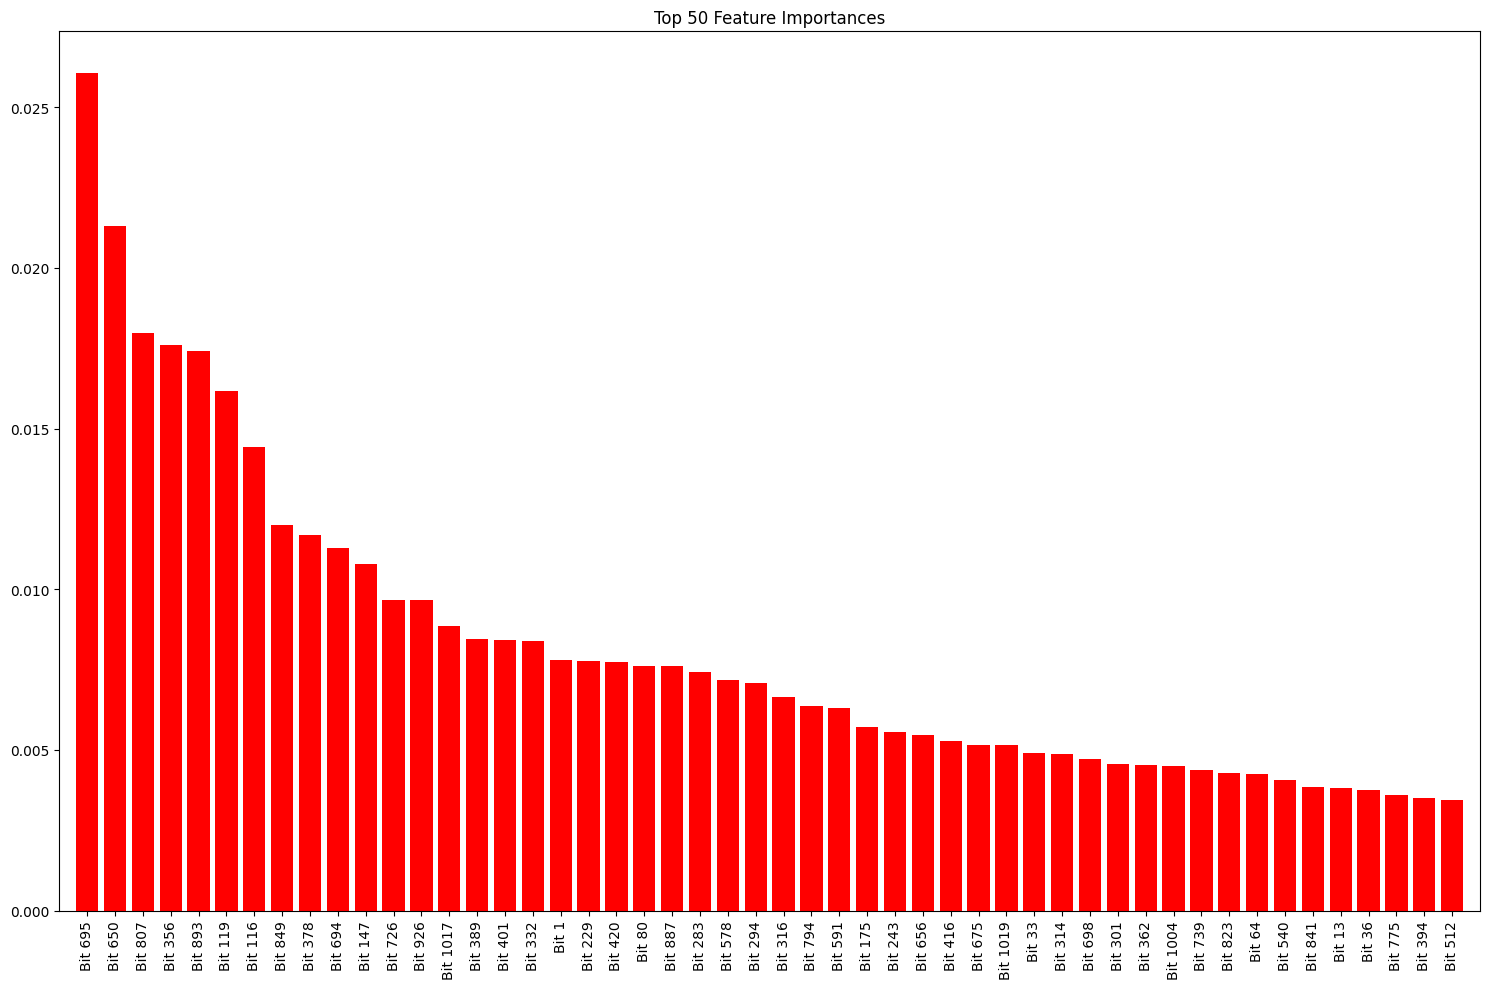

In [66]:
feature_importance(m_rf_manual_optimized, X_train)

# 11 k-means vs 11 expert manual clusters

## Randomized labels as baseline

In [3]:
# Randomize labels by shuffling each column independently
randomized_labels = labels_kmeans_11.apply(np.random.permutation, axis=0)

y_rand = np.array(randomized_labels, dtype=np.float64)
X = fingerprint

X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X, y_rand, test_size=0.2, random_state=12345)
print(f"training set with standard split is {len(y_train_rand)} items long and the test set is {len(y_test_rand)} items long")

m_rf = RandomForestClassifier(n_estimators = 10, max_features=100).fit(X_train_rand, y_train_rand)
y_pred_std = m_rf.predict(X_test_rand)

print(classification_report(y_test_rand, y_pred_std, zero_division=0))

training set with standard split is 2789 items long and the test set is 698 items long
              precision    recall  f1-score   support

           0       0.27      0.08      0.13       146
           1       0.23      0.07      0.11       177
           2       0.17      0.05      0.07       149
           3       0.25      0.10      0.14       167
           4       0.37      0.22      0.27       263
           5       0.38      0.23      0.29       267
           6       0.17      0.03      0.05       114
           7       0.29      0.05      0.08       177
           8       0.37      0.29      0.32       284
           9       0.10      0.01      0.02        73
          10       0.33      0.15      0.20       199

   micro avg       0.33      0.14      0.20      2016
   macro avg       0.27      0.11      0.15      2016
weighted avg       0.29      0.14      0.18      2016
 samples avg       0.23      0.13      0.15      2016



## Removing samples that are not present in expert manual label dataset

In [6]:
print(len(labels_kmeans_11))
labels_kmeans_11_subset = labels_kmeans_11[labels_kmeans_11.index.isin(labels_manual_expert.index)]
keep_rows_mask = labels_kmeans_11.index.isin(labels_kmeans_11_subset.index)
print(len(labels_kmeans_11_subset))

3487
3246


## Train-test split

In [36]:
y_filtered = np.array(labels_kmeans_11_subset, dtype=np.float64)
X = fingerprint
print(len(X))
# Use these positions to subset the NumPy array
X_filtered = X[keep_rows_mask]
print(len(X_filtered))

3487
3246


In [17]:
from skmultilearn.model_selection import iterative_train_test_split

X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=12345)
print(f"training set with standard split is {len(y_train_std)} items long and the test set is {len(y_test_std)} items long")

X_train_iter, y_train_iter, X_test_iter, y_test_iter = iterative_train_test_split(X_filtered, y_filtered, test_size = 0.2)
print(f"training set with iterative split is {len(y_train_iter)} items long and the test set is {len(y_test_iter)} items long")

training set with standard split is 2596 items long and the test set is 650 items long
training set with iterative split is 2574 items long and the test set is 672 items long


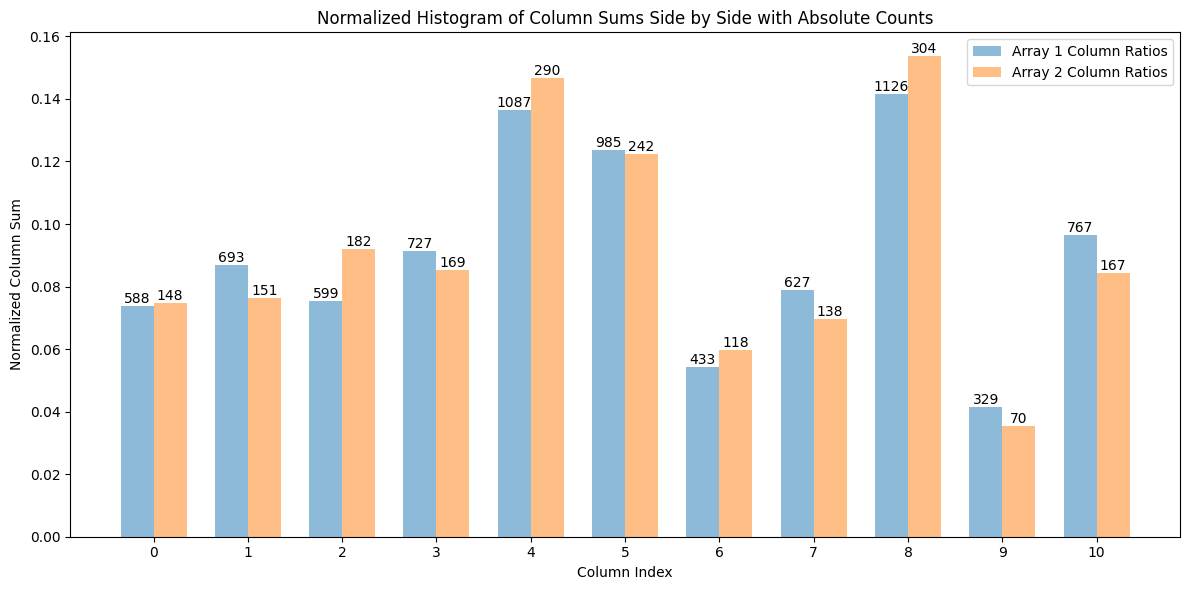

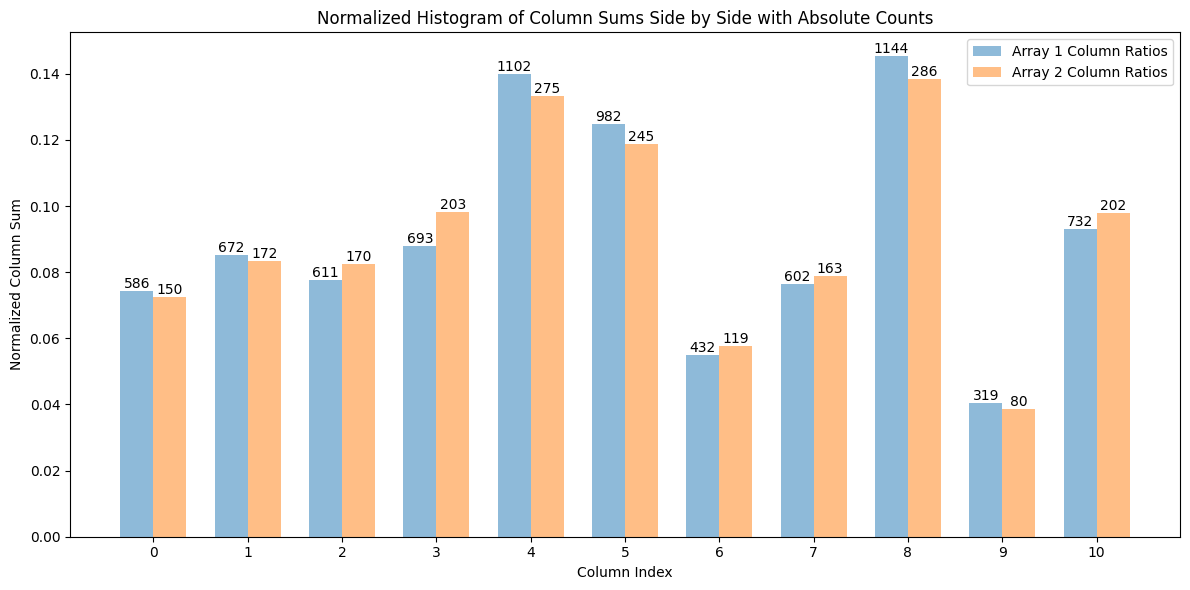

In [18]:
plot_cluster_counts_array(y_train_std, y_test_std)
plot_cluster_counts_array(y_train_iter, y_test_iter)

## Training unoptimized models

In [21]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 1).fit(X_train_std, y_train_std)
y_pred_std = m_rf.predict(X_test_std)

print(classification_report(y_test_std, y_pred_std, zero_division=0))

              precision    recall  f1-score   support

           0       0.67      0.46      0.55       148
           1       0.62      0.48      0.54       151
           2       0.55      0.19      0.28       182
           3       0.63      0.33      0.43       169
           4       0.77      0.60      0.67       290
           5       0.71      0.54      0.61       242
           6       0.63      0.22      0.33       118
           7       0.64      0.35      0.45       138
           8       0.72      0.58      0.64       304
           9       0.50      0.17      0.26        70
          10       0.60      0.41      0.48       167

   micro avg       0.68      0.44      0.53      1979
   macro avg       0.64      0.39      0.48      1979
weighted avg       0.66      0.44      0.52      1979
 samples avg       0.64      0.47      0.50      1979



In [22]:
m_rf_unoptimized = RandomForestClassifier(n_estimators = 10, max_features = 1).fit(X_train_iter, y_train_iter)
y_pred_unoptimized = m_rf_unoptimized.predict(X_test_iter)

print(classification_report(y_test_iter, y_pred_unoptimized, zero_division=0))

              precision    recall  f1-score   support

           0       0.67      0.42      0.52       150
           1       0.57      0.46      0.51       172
           2       0.42      0.16      0.24       170
           3       0.71      0.31      0.43       203
           4       0.79      0.61      0.69       275
           5       0.71      0.62      0.66       245
           6       0.47      0.24      0.31       119
           7       0.63      0.33      0.43       163
           8       0.63      0.60      0.62       286
           9       0.42      0.06      0.11        80
          10       0.64      0.38      0.48       202

   micro avg       0.65      0.43      0.52      2065
   macro avg       0.60      0.38      0.45      2065
weighted avg       0.63      0.43      0.50      2065
 samples avg       0.64      0.45      0.50      2065



Performance seems to be better when using the standard train test split function compared to the iterative train test function, so we will use the standard train test function 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=12345)
print(f"training set with standard split is {len(y_train)} items long and the test set is {len(y_test)} items long")

training set with standard split is 2596 items long and the test set is 650 items long


In [24]:
print(np.sum(y_test, axis=0))
print(np.sum(y_pred_std, axis=0))


[148. 151. 182. 169. 290. 242. 118. 138. 304.  70. 167.]
[101. 118.  62.  89. 225. 185.  41.  75. 242.  24. 114.]


In [ ]:
#m_rf.get_params()

## Random & Grid Search

In [26]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint as sp_randint
import numpy as np
import time

def optimize_rfc_grid_search(x_data, y_targets):
    # Random Forest classifier to be optimized
    rfc = RandomForestClassifier(random_state=2)

    # Step 1: Define the parameter space for RandomizedSearchCV
    param_dist = {
        "n_estimators": sp_randint(10, 750),
        "max_leaf_nodes": sp_randint(20, 1000),
        "max_depth": sp_randint(20, 500),
        "min_samples_split": sp_randint(2, 250),
        "max_features": sp_randint(3, 100)
    }

    # Step 2: Execute RandomizedSearchCV
    n_iter_search = 50  # Number of parameter settings that are sampled
    random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=make_scorer(f1_score, average='micro'), cv=4, verbose=1)
    
    start_time = time.time()
    random_search.fit(x_data, y_targets)

    print(f"Random Search completed in {time.time() - start_time:.2f} seconds. Starting Grid Search...")

    # Step 3: Identify the best parameters from the random search
    best_params = random_search.best_params_

    # Step 4: Define a narrower search space for GridSearchCV around the best parameters found
    param_grid = {
        "n_estimators": [best_params['n_estimators'] - 10, best_params['n_estimators'], best_params['n_estimators'] + 10],
        "max_leaf_nodes": [best_params['max_leaf_nodes'] - 20, best_params['max_leaf_nodes'], best_params['max_leaf_nodes'] + 20],
        "max_depth": [best_params['max_depth'] - 20, best_params['max_depth'], best_params['max_depth'] + 20],
        "min_samples_split": [best_params['min_samples_split'] - 10, best_params['min_samples_split'], best_params['min_samples_split'] + 10],
        "max_features": [max(1, best_params['max_features'] - 10), best_params['max_features'], best_params['max_features'] + 10]
    }

    # Step 5: Execute GridSearchCV
    grid_search = GridSearchCV(rfc, param_grid=param_grid, scoring=make_scorer(f1_score, average='micro'), cv=4, verbose=1)

    # Adjust ranges to ensure they are valid (e.g., positive integers)
    for key in param_grid.keys():
        param_grid[key] = [np.max([x, param_dist[key].a]) for x in param_grid[key]]  # Ensure within original bounds

    start_time = time.time()

    grid_search.fit(x_data, y_targets)

    print(f"Grid Search completed in {time.time() - start_time:.2f} seconds.")

    # Step 6: Report the best parameters found
    print("Best parameters found by grid search:", grid_search.best_params_)
    return grid_search.best_params_

# Call the function with your data and target variables
# best_params = optimize_rfc_with_random_and_grid_search(x_data, y_targets)

### Optimization and model training (k-means)

In [27]:
best_params_grid_kmeans_11 = optimize_rfc_grid_search(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Random Search completed in 203.34 seconds. Starting Grid Search...
Fitting 4 folds for each of 243 candidates, totalling 972 fits
Grid Search completed in 2263.48 seconds.
Best parameters found by grid search: {'max_depth': 214, 'max_features': 48, 'max_leaf_nodes': 704, 'min_samples_split': 2, 'n_estimators': 437}


In [30]:
m_rf_kmeans_11_optimized = RandomForestClassifier(n_estimators = int(best_params_grid_kmeans_11["n_estimators"]), max_depth = int(best_params_grid_kmeans_11["max_depth"]), max_leaf_nodes = int(best_params_grid_kmeans_11["max_leaf_nodes"]), min_samples_split = int(best_params_grid_kmeans_11["min_samples_split"]), max_features = int(best_params_grid_kmeans_11["max_features"])).fit(X_train, y_train)
y_pred = m_rf_kmeans_11_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69       148
           1       0.65      0.47      0.54       151
           2       0.69      0.26      0.38       182
           3       0.68      0.34      0.45       169
           4       0.82      0.68      0.74       290
           5       0.75      0.63      0.69       242
           6       0.59      0.31      0.40       118
           7       0.68      0.46      0.55       138
           8       0.72      0.68      0.70       304
           9       0.41      0.10      0.16        70
          10       0.64      0.40      0.49       167

   micro avg       0.71      0.51      0.59      1979
   macro avg       0.67      0.45      0.53      1979
weighted avg       0.70      0.51      0.58      1979
 samples avg       0.73      0.54      0.58      1979



In [31]:
print(m_rf_kmeans_11_optimized.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 214, 'max_features': 48, 'max_leaf_nodes': 704, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 437, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [32]:
# plot_cluster_counts_array(y_test, y_pred)

print(np.sum(y_test, axis=0))
print(np.sum(y_pred, axis=0))
print(np.array([0,1,2,3,4,5,6,7,8]))

m_rf_kmeans_11_optimized.get_params()

print(y_test, y_pred)

[148. 151. 182. 169. 290. 242. 118. 138. 304.  70. 167.]
[141. 110.  70.  84. 239. 203.  61.  94. 288.  17. 104.]
[0 1 2 3 4 5 6 7 8]
[[0. 0. 0. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]] [[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]]


### Optimization and model training (manual expert)

In [38]:
y = labels_manual_expert
X = fingerprint
print(len(X))
# Use these positions to subset the NumPy array
X_filtered = X[keep_rows_mask]
print(len(X_filtered))

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=12345)

3487
3246


In [39]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 1).fit(X_train, y_train)
y_pred = m_rf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.63      0.37      0.47       173
           1       0.78      0.72      0.75       355
           2       0.68      0.40      0.50       141
           3       0.76      0.68      0.72       284
           4       0.50      0.07      0.12        15
           5       0.56      0.21      0.31       118
           6       1.00      0.09      0.16        23
           7       1.00      0.06      0.11        33
           8       0.86      0.13      0.22        47
           9       0.62      0.41      0.49        64
          10       0.48      0.12      0.19        99

   micro avg       0.72      0.48      0.57      1352
   macro avg       0.71      0.30      0.37      1352
weighted avg       0.71      0.48      0.54      1352
 samples avg       0.65      0.52      0.54      1352



In [40]:
best_params_grid_manual_expert = optimize_rfc_grid_search(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Random Search completed in 248.93 seconds. Starting Grid Search...
Fitting 4 folds for each of 243 candidates, totalling 972 fits
Grid Search completed in 3863.82 seconds.
Best parameters found by grid search: {'max_depth': 304, 'max_features': 53, 'max_leaf_nodes': 448, 'min_samples_split': 2, 'n_estimators': 507}


In [42]:
m_rf_manual_expert_optimized = RandomForestClassifier(n_estimators = int(best_params_grid_manual_expert["n_estimators"]), max_depth = int(best_params_grid_manual_expert["max_depth"]), max_leaf_nodes = int(best_params_grid_manual_expert["max_leaf_nodes"]), min_samples_split = int(best_params_grid_manual_expert["min_samples_split"]), max_features = int(best_params_grid_manual_expert["max_features"])).fit(X_train, y_train)
y_pred = m_rf_manual_expert_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.70      0.34      0.45       173
           1       0.80      0.79      0.79       355
           2       0.72      0.43      0.54       141
           3       0.76      0.75      0.75       284
           4       0.50      0.07      0.12        15
           5       0.59      0.20      0.30       118
           6       0.00      0.00      0.00        23
           7       1.00      0.03      0.06        33
           8       0.69      0.23      0.35        47
           9       0.80      0.25      0.38        64
          10       0.67      0.12      0.21        99

   micro avg       0.75      0.50      0.60      1352
   macro avg       0.66      0.29      0.36      1352
weighted avg       0.72      0.50      0.56      1352
 samples avg       0.73      0.56      0.60      1352



## Feature importance

In [43]:
def feature_importance(model, X_train):

    # Extract feature importances
    feature_importances = model.feature_importances_

    # Create generic feature names if not already provided
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f"Bit {i}" for i in range(X_train_std.shape[1])]

    # Sort the feature importances in descending order and get the indices
    indices = np.argsort(feature_importances)[::-1]

    # Select the top 50 features
    top_indices = indices[:50]
    
    # Adjust the size of the plot to accommodate 50 features nicely
    plt.figure(figsize=(15, 10))
    plt.title("Top 50 Feature Importances")
    plt.bar(range(50), feature_importances[top_indices], color="r", align="center")
    
    # Set the ticks to be the names of the top 50 features
    plt.xticks(range(50), [feature_names[i] for i in top_indices], rotation=90)
    plt.xlim([-1, 50])
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

### K-means

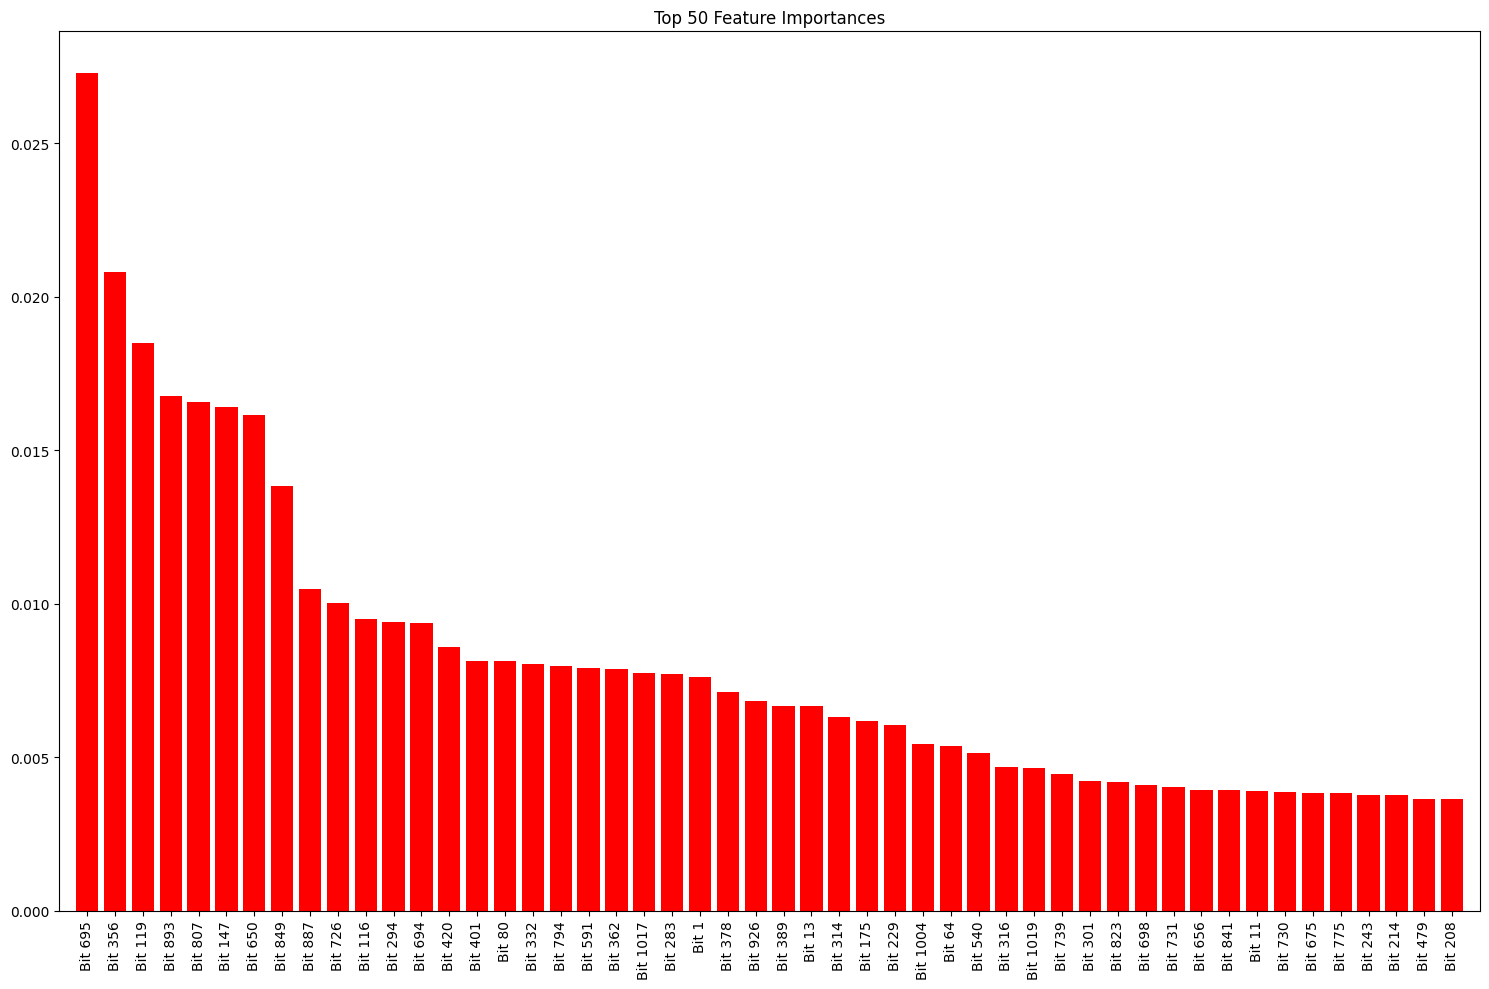

In [44]:
feature_importance(m_rf_kmeans_11_optimized, X_train)

### Manual 

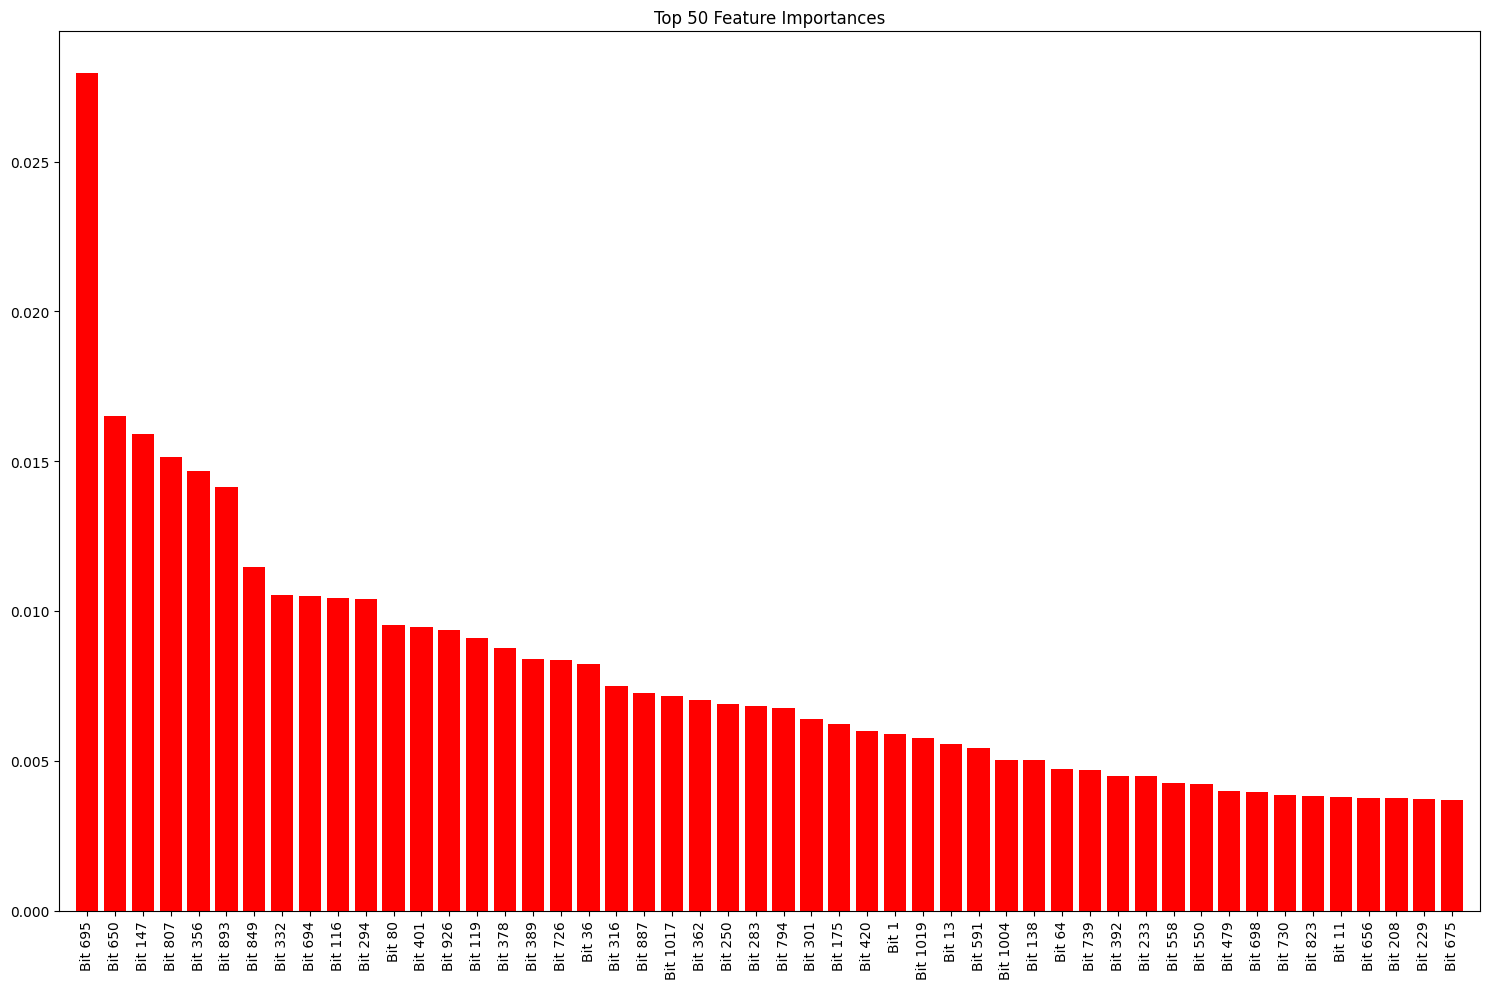

In [46]:
feature_importance(m_rf_manual_expert_optimized, X_train)